# MASS V3 Re-implementation

- Reimplementing MASS V3 in-house to better understand the inner workings + convert into python

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import time
import mass_ts as mts

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

PLACE_HOLDER = None

c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\mass_ts\_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


## Recreate MASS V3 here:

#### Function IO

In [ ]:
def mass_v3(x, y, k):
    """
    Parameters:
    x : Long time series data (numpy array)
    y : Query sequence (numpy array)  
    k : Size of pieces, preferably a power of two (int)
    
    Returns:
    dist : Distance profile (numpy array)
    """

# MASS V3 Function Implementation

In [ ]:
x = PLACE_HOLDER
y = PLACE_HOLDER

In [ ]:
# Length of query and data
m = len(y)
n = len(x)
dist = []

In [ ]:
# Compute statistics for the query y
meany = np.mean(y)
sigmay = np.std(y, ddof=0)

In [ ]:
# Compute moving mean and standard deviation for x
meanx = np.convolve(x, np.ones(m), 'valid') / m
sum_sq = np.convolve(x ** 2, np.ones(m), 'valid')
sigmax = np.sqrt((sum_sq - m * meanx ** 2) / m)

In [ ]:
# Reverse the query and pad with zeros to match size k
y = y[::-1]
y = np.concatenate((y, np.zeros(k - m)))

In [ ]:
 # Loop through segments of the time series
for j in range(0, n - k + 1, k - m + 1):
    # Get segment from x and compute FFTs
    X = np.fft.fft(x[j:j + k])
    Y = np.fft.fft(y)

    # Element-wise multiplication in frequency domain and inverse FFT
    Z = X * Y
    z = np.fft.ifft(Z)

    # Compute distance profile for the segment
    d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))
    dist.extend(np.sqrt(np.real(d)))

# Handle the last segment if it is longer than the query
j = j + k - m
remaining_length = n - j
if remaining_length >= m:
    # Get the remaining segment from x and adjust query size
    X = np.fft.fft(x[j:])
    y = y[:remaining_length]
    Y = np.fft.fft(y)

    # Element-wise multiplication in frequency domain and inverse FFT
    Z = X * Y
    z = np.fft.ifft(Z)

    # Compute distance profile for the remaining segment
    d = 2 * (m - (z[m - 1:remaining_length] - m * meanx[j:j + remaining_length - m + 1] * meany) / (sigmax[j:j + remaining_length - m + 1] * sigmay))
    dist.extend(np.sqrt(np.real(d)))

# Complete MASS V3 Function


#### My Implementation (Direct Translation from MATLAB MASS V3 Code)

In [5]:
# Function to calculate distance profile using MASS V3
def mass_v3(x, y, k):
    """
    Parameters:
    x : numpy array
        Long time series data
    y : numpy array
        Query sequence
    k : int
        Size of pieces, preferably a power of two
    
    Returns:
    dist : numpy array
        Distance profile
    """
    # Length of query and data
    m = len(y)
    n = len(x)
    dist = []

    # Compute statistics for the query y
    meany = np.mean(y)
    sigmay = np.std(y, ddof=0)

    # Avoid divide by zero by ensuring sigmay is non-zero
    if sigmay == 0:
        sigmay = 1e-10

    # Compute moving mean and standard deviation for x
    meanx = np.convolve(x, np.ones(m), 'valid') / m
    sum_sq = np.convolve(x ** 2, np.ones(m), 'valid')
    sigmax = np.sqrt((sum_sq - m * meanx ** 2) / m)

    # Replace zeros in sigmax to avoid divide by zero
    sigmax[sigmax == 0] = 1e-10

    # Reverse the query and pad with zeros to match size k
    y = y[::-1]
    y = np.concatenate((y, np.zeros(k - m)))

    # Loop through segments of the time series
    for j in range(0, n - k + 1, k - m + 1):
        # Get segment from x and compute FFTs
        X = np.fft.fft(x[j:j + k])
        Y = np.fft.fft(y)

        # Element-wise multiplication in frequency domain and inverse FFT
        Z = X * Y
        z = np.fft.ifft(Z)

        # Compute distance profile for the segment
        d = 2 * (m - (z[m - 1:k] - m * meanx[j:j + k - m + 1] * meany) / (sigmax[j:j + k - m + 1] * sigmay))
        dist.extend(np.sqrt(np.real(d)))

    # Handle the last segment if it is longer than the query
    j = j + k - m
    remaining_length = n - j
    if remaining_length >= m:
        # Get the remaining segment from x and adjust query size
        X = np.fft.fft(x[j:])
        y = y[:remaining_length]
        Y = np.fft.fft(y)

        # Element-wise multiplication in frequency domain and inverse FFT
        Z = X * Y
        z = np.fft.ifft(Z)

        # Compute distance profile for the remaining segment
        d = 2 * (m - (z[m - 1:remaining_length] - m * meanx[j:j + remaining_length - m + 1] * meany) / (sigmax[j:j + remaining_length - m + 1] * sigmay))
        dist.extend(np.sqrt(np.real(d)))

    return np.array(dist)

#### Implementation by Tyler Marrs: [Github Link](https://github.com/tylerwmarrs/mass-ts/blob/master/mass_ts/_mass_ts.py)

In [ ]:
def mass3_tyler_marrs(ts, query, pieces):
    """
    Compute the distance profile for the given query over the given time 
    series. This version of MASS is hardware efficient given the right number
    of pieces.

    Parameters
    ----------
    ts : array_like
        The array to create a rolling window on.
    query : array_like
        The query.
    pieces : int
        Number of pieces to process. This is best as a power of 2.

    Returns
    -------
    An array of distances.

    Raises
    ------
    ValueError
        If ts is not a list or np.array.
        If query is not a list or np.array.
        If ts or query is not one dimensional.
        If pieces is less than the length of the query.
    """
    ts, query = mtscore.precheck_series_and_query(ts, query)

    m = len(query)
    
    if pieces < m:
        raise ValueError('pieces should be larger than the query length.')
    
    n = len(ts)
    k = pieces
    x = ts
    dist = np.array([])
    
    # compute stats in O(n)
    meany = np.mean(query)
    sigmay = np.std(query)
    
    meanx = mtscore.moving_average(x, m)
    meanx = np.append(np.ones([1, len(x) - len(meanx)]), meanx)
    sigmax = mtscore.moving_std(x, m)
    sigmax = np.append(np.zeros([1, len(x) - len(sigmax)]), sigmax)
    
    # reverse the query and append zeros
    y = np.append(np.flip(query), np.zeros(pieces - m))
    
    step_size = k - m + 1
    stop = n - k + 1
       
    for j in range(0, stop, step_size):
        # The main trick of getting dot products in O(n log n) time
        X = np.fft.fft(x[j:j + k])
        Y = np.fft.fft(y)
        
        Z = X * Y
        z = np.fft.ifft(Z)
            
        d = 2 * (m-(z[m - 1:k] - m * meanx[m + j - 1:j + k] * meany) /
                   (sigmax[m + j - 1:j + k] * sigmay))
        d = np.sqrt(d)
        dist = np.append(dist, d)
   
    j = j + k - m
    k = n - j - 1
    if k >= m:
        X = np.fft.fft(x[j:n-1])
        y = y[0:k]

        Y = np.fft.fft(y)
        Z = X * Y
        z = np.fft.ifft(Z)

        d = 2 * (m-(z[m - 1:k] - m * meanx[j + m - 1:n - 1] * meany) /
                 (sigmax[j + m - 1:n - 1] * sigmay))
       
        d = np.sqrt(d)
        dist = np.append(dist, d)
    
    return np.array(dist)

### Function for determining the optimal value for k (number of pieces):

In [4]:
def determine_k(n, m):
    """
    Determines the optimal value of k for MASS V3.
    
    Parameters:
    n : Length of the time series (int) 
    m : Length of the query (int)

    Returns:
    k : Optimal segment size, preferably a power of two (int)
    """
    # Set k to be the next power of two greater than or equal to 4 times the query length
    k = 2 ** int(np.ceil(np.log2(max(4 * m, m))))
    # Ensure k is not greater than the length of the time series
    k = min(k, n)
    return k

# Algorithm Benchmarking
- Lets look at the time complexity of each of these functions as a baseline

In [2]:
# Load the query and trip data (1 query and 1 trip)
x = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\x_trip_5109.csv')
y = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\y_query_7.csv')


In [6]:
# Determine the optimal segment size
n = len(x)
m = len(y)
k = determine_k(n, m)

In [7]:
# The initial columns to compare in the time series data
columns = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_jerk_mps3_analytical']

In [9]:
# Print out test description saying that the test is for Tyler Marrs MASS V3 implementation
print("Test Description: This test is for my (Donaven Lobo) MASS V3 implementation")

start_time = time.time()

combined_distance_profile1 = mass_v3(x[columns[0]].values, y[columns[0]].values, k)  # Initialize combined distance profile

# Loop through each column and compute the distance profile
for col in columns:
    if col == columns[0]:
        continue
    distance_profile = mass_v3(x[col].values, y[col].values, k)
    combined_distance_profile1 += distance_profile  # Sum the distance profiles

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Test Description: This test is for my (Donaven Lobo) MASS V3 implementation
Time taken: 0.046559810638427734 seconds


In [10]:
# Print out test description saying that the test is for Tyler Marrs MASS V3 implementation
print("Test Description: This test is for Tyler Marrs MASS V3 implementation")

start_time = time.time()

combined_distance_profile2 = mts.mass3(x[columns[0]].values, y[columns[0]].values, k)  # Initialize combined distance profile

# Loop through each column and compute the distance profile
for col in columns:
    if col == columns[0]:
        continue
    distance_profile = mts.mass3(x[col].values, y[col].values, k)
    combined_distance_profile2 += distance_profile  # Sum the distance profiles

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Test Description: This test is for Tyler Marrs MASS V3 implementation
Time taken: 0.056018829345703125 seconds


c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\mass_ts\_mass_ts.py:265: RuntimeWarning: divide by zero encountered in divide
  d = 2 * (m-(z[m - 1:k] - m * meanx[m + j - 1:j + k] * meany) /
c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\mass_ts\_mass_ts.py:265: RuntimeWarning: invalid value encountered in divide
  d = 2 * (m-(z[m - 1:k] - m * meanx[m + j - 1:j + k] * meany) /
c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\mass_ts\_mass_ts.py:265: RuntimeWarning: invalid value encountered in multiply
  d = 2 * (m-(z[m - 1:k] - m * meanx[m + j - 1:j + k] * meany) /


# Analysis
- What does this new distance profile look like?

In [14]:
# Plot Distance Profile Function using seaborn
def plot_distance_profile(distance_profile, title):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=distance_profile)
    plt.title(f'{title}', fontsize=16, fontweight='bold')
    plt.xlabel('Index', fontsize=14)
    plt.ylabel('Euclidean Distance', fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.show()

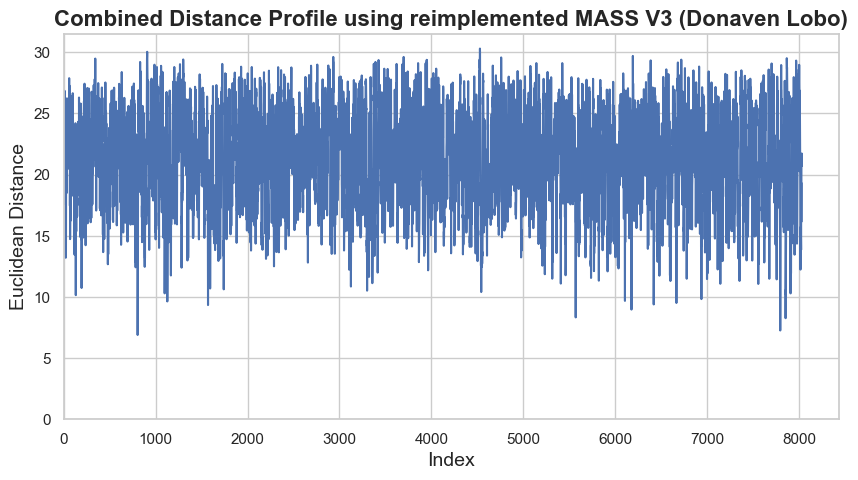

In [15]:
# Plot the combined distance profile for the reimplemented MASS V3
plot_distance_profile(combined_distance_profile1, 'Combined Distance Profile using reimplemented MASS V3 (Donaven Lobo)')

c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\near_miss_env\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


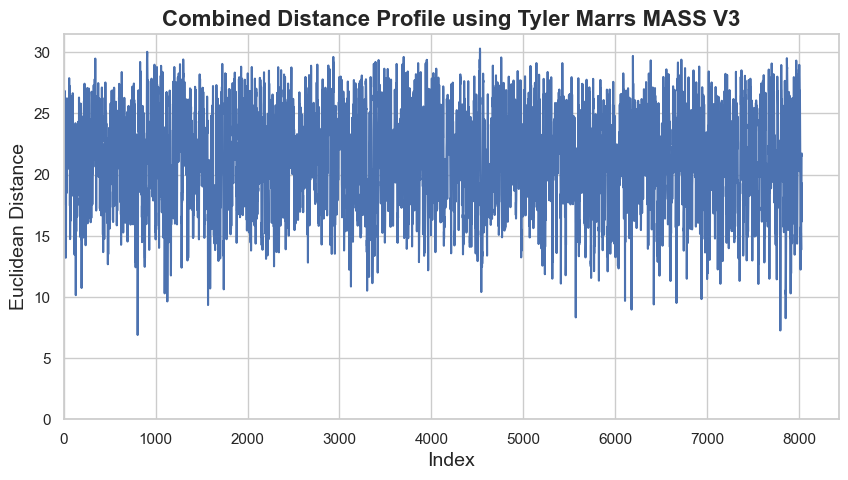

In [16]:
# Plot the combined distance profile for the Tyler Marrs MASS V3
plot_distance_profile(combined_distance_profile2, 'Combined Distance Profile using Tyler Marrs MASS V3')